# Projektarbeit Data Analytics

Sebastian Jana,
Sophie Jana

## Inhaltsverzeichnis
<a id ="inhaltsverzeichnis"></a>

[1. Aufgabe](#aufgabe1)

[2. Aufgabe](#aufgabe2)

[3. Aufgabe](#aufgabe3)

4. Aufgabe
5. Aufgabe

[6. Aufgabe](#aufgabe6)

[7. Quellenverzeichnis](#quellenverzeichnis)




### Aufgabe 1 (Datenvorbereitung)
<a id = "aufgabe1"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)

a) Einlesen der CSV Dateien, welche die Stromerzeugungsdaten und die Börsenstrompreise enthalten, als Dataframe df_hourly.

Nach dem ersten Zusammenführen haben wir festgestellt, dass die Datumsspalte je nach CSV-Datei unterschiedliche Namen für Sommerzeit und Winterzeit hat. Dies führt dazu, dass beim Zusammenführen zwei separate Spalten entstehen. Um dies zu vermeiden, prüfen wir bereits beim Einlesen der Dateien die Spaltennamen und führen sie zu einer einheitlichen Spalte „Datum“ im df_hourly zusammen


In [174]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [175]:
# Sources for reading csv files from one folder[1],[2]
path = './Daten/Strompreisdaten'
# List all files (.csv) in the given path
csv_files = glob.glob(os.path.join(path, "*csv"))

df_list = []
for i in range(len(csv_files)):
    try:
        df_temp = pd.read_csv(csv_files[i], sep = ",")
        for column in df_temp.columns:
            # Combine the date columns, by getting rid of the naming difference in csv source
            if 'Datum (MESZ)' in column:
                df_temp = df_temp.rename(columns = {'Datum (MESZ)':'DateTime'})
            elif 'Datum (MEZ)' in column:
                df_temp = df_temp.rename(columns = {'Datum (MEZ)':'DateTime'})
        df_list.append(df_temp)
    except Exception as err: 
        print("Fehler beim Einlesen des Files: ", err)
    
df_hourly = pd.concat(df_list)
df_hourly


,DateTime,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Day Ahead Auktion Preis (EUR/MWh)
0,2019-12-30 00:00:00,14233.89,29930.56,11.07
1,2019-12-30 01:00:00,14154.34,30166.97,11.84
2,2019-12-30 02:00:00,13251.87,30427.25,6.16
3,2019-12-30 03:00:00,13186.11,31289.24,1.40
4,2019-12-30 04:00:00,13045.57,32203.27,4.81
...,...,...,...,...
211,2024-12-31 19:00:00,21383.15,38916.54,67.77
212,2024-12-31 20:00:00,18556.76,40027.68,35.56
213,2024-12-31 21:00:00,15780.62,40653.76,15.70
214,2024-12-31 22:00:00,14930.74,40116.86,9.06


b) Zur besseren anschließenden Analyse überführen wir die Datumsspalte (vorher dytpe: object) in ein Date-Time-Format. Überprüfung, ob nach der Konvertierung invalide Datumswerte existieren, was nicht der Fall ist.
Alle anderen Spalten haben den dtype float64 und werden so belassen.
Entfernung aller Datensätze, die nicht im Betrachtungszeitraum liegen (2020-2024). Durch Filterung über das Jahr werden 48 Einträge entfernt, da diese nicht in den Betrachtungszeitraum fallen.

In [176]:
print(df_hourly.shape)
# Converting the column "DateTime" from object to DateTime format
# Invalid values are converted to NaT (Not a Time)
# Source: [3]
df_hourly['DateTime'] = pd.to_datetime(df_hourly['DateTime'], errors="coerce")
print(df_hourly.dtypes)
print(df_hourly['DateTime'].isna().any())


# Create column "Date" from column "DateTime" [4]
df_hourly = df_hourly[(df_hourly['DateTime'].dt.year >= 2020) & (df_hourly['DateTime'].dt.year <= 2024)]

# 48 rows deleted
print(df_hourly.shape) 



(43896, 4)
DateTime                             datetime64[ns]
Leistung nicht erneuerbar (MW)              float64
Leistung erneuerbar (MW)                    float64
Day Ahead Auktion Preis (EUR/MWh)           float64
dtype: object
False
(43848, 4)


c) Beurteilung der Datenqualität und notwenige Datenbereinigungsschritte. 
Qualität der Datumsdaten wurde durch Konvertierung schon überprüft. df_hourly enthält nur Werte für die Jahre 2020-2024. Dataframe enthält keine Null-Werte.

In [177]:
# Check for missing values
print(df_hourly.isnull().sum())
print(df_hourly.notnull().sum())



DateTime                             0
Leistung nicht erneuerbar (MW)       0
Leistung erneuerbar (MW)             0
Day Ahead Auktion Preis (EUR/MWh)    0
dtype: int64
DateTime                             43848
Leistung nicht erneuerbar (MW)       43848
Leistung erneuerbar (MW)             43848
Day Ahead Auktion Preis (EUR/MWh)    43848
dtype: int64


d) Erzeugung eines Dataframes df_daily, das für jeden Tag die aggregierten Werte der Leistung der erneuerbaren und nicht erneuerbaren Energiequellen, sowie den täglichen Mittelwert des Börsenpreis enthält. Diese Art der Gruppierung ist sinnvoll für die weitere Analyse, um Trends auf Tagesbasis zu analysieren.

Zur Gruppierung nach Tagen machen wir aus der DateTime nur noch das Datum, indem wir die Uhrzeit entfernen. Anschließend gruppieren wir die Daten nach Datum, wobei die Leistung nicht erneuerbarer und erneuererbarer Energie jeweils für den Tag aufsummiert wird. Zudem gruppieren wir nochmals nach dem Tag und berechnen für jeden Tag den mittleren Börsenpreis. Abschließend joinen wir zu einem gemeinsamen Dataframe df_daily.

In [178]:
# Grouping by the date without time
# We use a copy to avoid the SettingWithCopyWarning that occurs when we modifiy a view of the original df [5]

df_stunde = df_hourly.copy()

df_stunde['Datum'] = df_stunde['DateTime'].dt.date

df_daily = df_stunde.groupby('Datum')[['Leistung nicht erneuerbar (MW)', 'Leistung erneuerbar (MW)' ]].sum()

df_mean = df_stunde.groupby('Datum')['Day Ahead Auktion Preis (EUR/MWh)'].mean()

df_daily = pd.merge(df_daily, df_mean, on='Datum', how='left').reset_index()

# Change Datum again to datetime format

df_daily['Datum'] = pd.to_datetime(df_daily['Datum'])

df_daily


,Datum,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Day Ahead Auktion Preis (EUR/MWh)
0,2020-01-01,468837.03,441093.57,34.964167
1,2020-01-02,505002.46,605620.76,38.869167
2,2020-01-03,427798.33,968577.88,26.111250
3,2020-01-04,411321.40,987041.46,20.322917
4,2020-01-05,508187.80,514534.00,35.552500
...,...,...,...,...
1822,2024-12-27,708574.01,268571.36,121.706250
1823,2024-12-28,700316.27,275162.43,122.638333
1824,2024-12-29,615408.50,547203.48,105.280417
1825,2024-12-30,607675.26,783569.49,78.155833


### Aufgabe 2 (Explorative Analyse der Stromerzeugungs- und Preisdaten)
<a id = "aufgabe2"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)


a) An Welchen 10 Tagen im Betrachtungszeitraum wurden am meisten Strom aus erneuerbaren Energieträgern erzeugt?

Wir beobachten, dass die Tage, an denen der meiste Strom aus erneuererbaren Energieträgern erzeugt wurde, vorwiegend in die Monate Dezember und Februar fallen. 

In [179]:
ten_highest_days = df_daily.sort_values(by = 'Leistung erneuerbar (MW)', ascending=False).head(10)
ten_highest_days


,Datum,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Day Ahead Auktion Preis (EUR/MWh)
1497,2024-02-06,331773.90,1380463.41,45.292917
1496,2024-02-05,331039.23,1358926.97,35.840833
1484,2024-01-24,351983.99,1316391.11,33.122917
1450,2023-12-21,275886.68,1308032.94,25.280417
1451,2023-12-22,242307.14,1289984.86,22.655833
827,2022-04-07,396999.16,1274027.01,74.153333
778,2022-02-17,381238.33,1271433.30,68.637083
1731,2024-09-27,198813.32,1269933.18,14.757500
1458,2023-12-29,221981.80,1261365.77,6.359583
41,2020-02-11,351153.81,1257586.20,11.620000


b) An welchem Tag im Betrachtungszeitraum wurde der höchste Börsenstrompreis verzeichnet und wie hoch war er? (26.08.22)
An welchem Tag im Betrachtungszeitraum wurde der niedrigste Börsenstrompreis verzeichnet und wie hoch war er? (2.7.23)

In [180]:
highest_price = df_daily['Day Ahead Auktion Preis (EUR/MWh)'].max()
date_highest_price = df_daily[df_daily['Day Ahead Auktion Preis (EUR/MWh)'] == highest_price]

print("Tag mit dem höchsten Börsenstrompreis: " ,date_highest_price['Datum'].dt.date.values[0])
print("Höchster Börsenstrompreis: ", highest_price)

lowest_price = df_daily['Day Ahead Auktion Preis (EUR/MWh)'].min()
date_lowest_price = (df_daily.loc[df_daily['Day Ahead Auktion Preis (EUR/MWh)'] == lowest_price])
print("Tag mit dem niedrigsten Börsenstrompreis: ", date_lowest_price['Datum'].dt.date.values[0])
print("Niedrigster Börsenstrompreis", lowest_price)


Tag mit dem höchsten Börsenstrompreis:  2022-08-26
Höchster Börsenstrompreis:  699.4416666666666
Tag mit dem niedrigsten Börsenstrompreis:  2023-07-02
Niedrigster Börsenstrompreis -53.87083333333334


c) Wie viele Tage gab es im Betrachtungszeitraum 2020-2024, an denen ein negativer Börsenstrompreis aufgetreten ist?

In [181]:
negative_price_df = df_daily[df_daily['Day Ahead Auktion Preis (EUR/MWh)'] < 0]
negative_price_day_count = negative_price_df['Day Ahead Auktion Preis (EUR/MWh)'].count()
print("Anzahl der Tage mit einem negativen Börsenstrompreis: ", negative_price_day_count)
negative_price_df


Anzahl der Tage mit einem negativen Börsenstrompreis:  13


,Datum,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Day Ahead Auktion Preis (EUR/MWh)
46,2020-02-16,252739.69,1152357.76,-8.274167
52,2020-02-22,243166.11,1236952.50,-1.508750
81,2020-03-22,260187.93,969434.27,-0.947083
103,2020-04-13,204282.71,875000.49,-15.966250
111,2020-04-21,218578.73,1151305.34,-16.149583
144,2020-05-24,205203.09,858451.60,-26.130833
186,2020-07-05,188708.17,976626.02,-15.337083
361,2020-12-27,236977.55,1093977.66,-13.452917
460,2021-04-05,227435.87,1056971.92,-16.996667
507,2021-05-22,189386.15,1076837.53,-7.039167


d) Wie viel Strom wurde pro Jahr mit erneuerbaren und mit nicht erneuerbaren Energieträgern erzeugt?

In [182]:
df_daily['Jahr'] = df_daily['Datum'].astype(str)
df_daily['Jahr'] = df_daily['Jahr'].str[0:4]
df_year = df_daily.groupby('Jahr')[['Leistung nicht erneuerbar (MW)', 'Leistung erneuerbar (MW)']].sum()

#Convert from megawatts (MW) to gigawatts (GW)

df_year['Leistung nicht erneuerbar (GW)'] = (df_year['Leistung nicht erneuerbar (MW)']/1000).round(2)
df_year['Leistung erneuerbar (GW)'] = (df_year['Leistung erneuerbar (MW)']/1000).round(2)
df_year



,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Leistung nicht erneuerbar (GW),Leistung erneuerbar (GW)
Jahr,,,,
2020,1.870113e+08,2.392726e+08,187011.33,239272.61
2021,2.093507e+08,2.220113e+08,209350.67,222011.27
2022,2.168424e+08,2.380835e+08,216842.36,238083.52
2023,1.653949e+08,2.534251e+08,165394.89,253425.13
2024,1.532793e+08,2.599273e+08,153279.32,259927.26


## Aufgabe 3 (Weiterfürhende Analyse der Stromerzeugung- und Preisdaten)
<a id = "aufgabe3"></a>


[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)


a) Visualisierung der Verteilung der Börsenstrompreise (insgesamt und pro Jahr)

??? Was ist hier mit Verteilung gemeint? evtl Boxplot??


Text(0.5, 1.0, 'Mittlerer Börsenstrompreis pro Tag für 2020-2024')

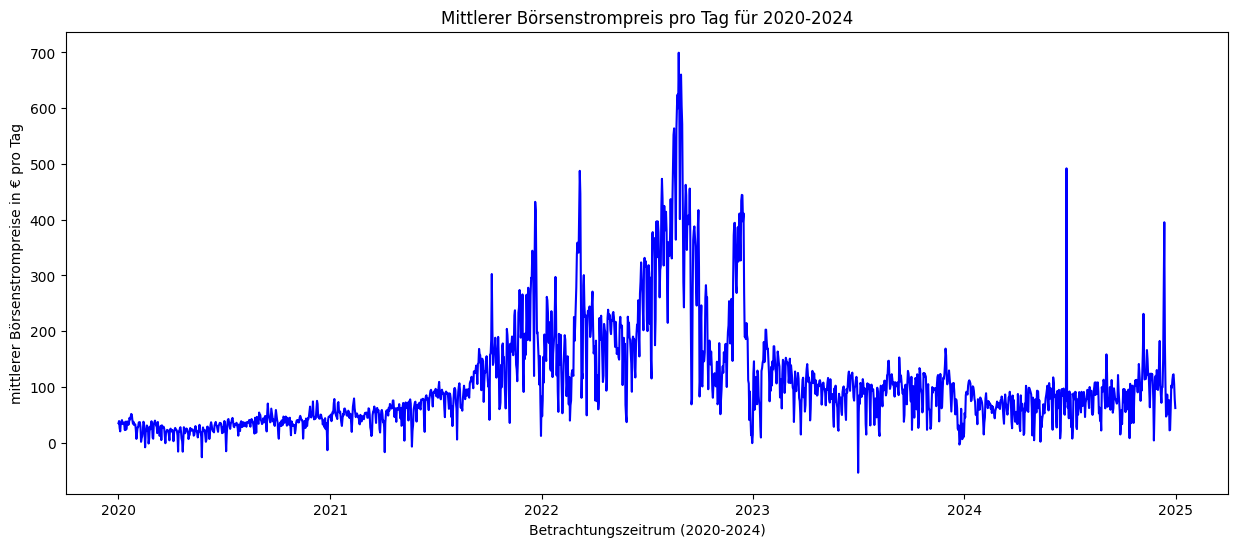

In [183]:
# "Line chart to show the distribution of prices per day for the observation period

plt.figure(figsize=(15, 6))
plt.plot(df_daily['Datum'], df_daily['Day Ahead Auktion Preis (EUR/MWh)'], label = 'Line', color = 'blue')
plt.xlabel('Betrachtungszeitrum (2020-2024)')
plt.ylabel('mittlerer Börsenstrompreise in € pro Tag')
plt.title('Mittlerer Börsenstrompreis pro Tag für 2020-2024')



Visualisierung der Verteilung der Börsenstrompreise pro Jahr? (evtl dann 4 Linien untereinander?)
->eher mittlerer Werte pro Monat aber dann Wiederholung in b)?
->oder nur die 5 Säulen mit mittlerer Wert pro Jahr?

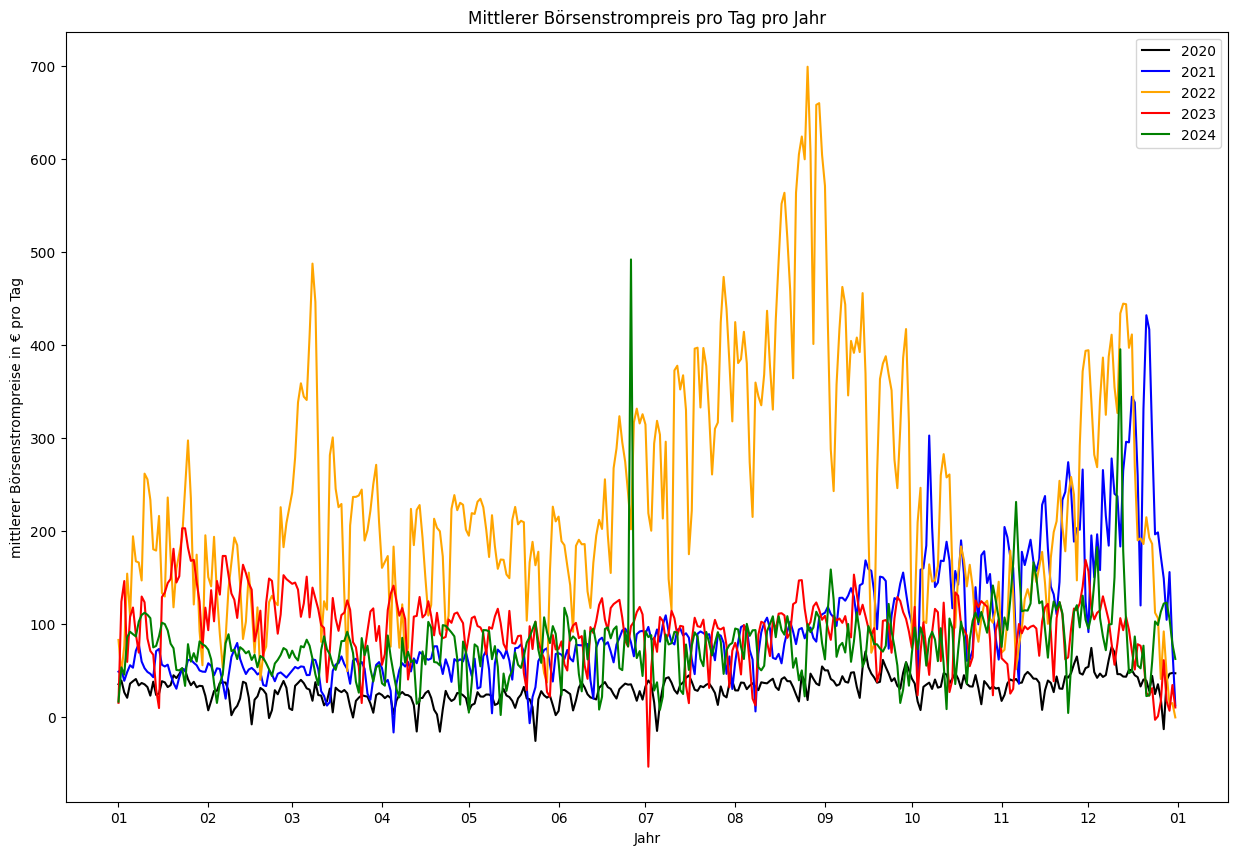

In [184]:
import matplotlib.dates as mdates
#Using column Jahr, which contains year as string
# We use a copy to avoid the SettingWithCopyWarning that occurs when we modifiy a view of the original df [5]
year_2020_modified = df_daily[df_daily['Jahr'] == '2020'].copy()
year_2021_modified = df_daily[df_daily['Jahr'] == '2021'].copy()
year_2022_modified = df_daily[df_daily['Jahr'] == '2022'].copy()
year_2023_modified = df_daily[df_daily['Jahr'] == '2023'].copy()
year_2024_modified = df_daily[df_daily['Jahr'] == '2024'].copy()

year_2020_modified['Datum'] = year_2020_modified['Datum'].astype(str)
year_2021_modified['Datum'] = year_2021_modified['Datum'].astype(str)
year_2022_modified['Datum'] = year_2022_modified['Datum'].astype(str)
year_2023_modified['Datum'] = year_2023_modified['Datum'].astype(str)
year_2024_modified['Datum'] = year_2024_modified['Datum'].astype(str)

# ertste Vorkommen von Jahr auf 2000 setzten, um Darstellung auf einer x-Achse zu ermöglichen

year_2020_modified['Datum'] = year_2020_modified['Datum'].str.replace('2020', '2000')
year_2021_modified['Datum'] = year_2021_modified['Datum'].str.replace('2021', '2000')
year_2022_modified['Datum'] = year_2022_modified['Datum'].str.replace('2022', '2000')
year_2023_modified['Datum'] = year_2023_modified['Datum'].str.replace('2023', '2000')
year_2024_modified['Datum'] = year_2024_modified['Datum'].str.replace('2024', '2000')



year_2020_modified['Datum'] = pd.to_datetime(year_2020_modified['Datum'])
year_2021_modified['Datum'] = pd.to_datetime(year_2021_modified['Datum'])
year_2022_modified['Datum'] = pd.to_datetime(year_2022_modified['Datum'])
year_2023_modified['Datum'] = pd.to_datetime(year_2023_modified['Datum'])
year_2024_modified['Datum'] = pd.to_datetime(year_2024_modified['Datum'])

plt.figure(figsize=(15, 10))
plt.plot(year_2020_modified['Datum'], year_2020_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2020', color = 'black')
plt.plot(year_2021_modified['Datum'], year_2021_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2021', color = 'blue')
plt.plot(year_2022_modified['Datum'], year_2022_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2022', color = 'orange')
plt.plot(year_2023_modified['Datum'], year_2023_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2023', color = 'red')
plt.plot(year_2024_modified['Datum'], year_2024_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2024', color = 'green')


plt.xlabel("Jahr")
plt.ylabel('mittlerer Börsenstrompreise in € pro Tag')
plt.title('Mittlerer Börsenstrompreis pro Tag pro Jahr')
plt.legend(loc='upper right')


# Source [6] Chat-GPT mit Prompt
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Setzt die Haupt-Ticks auf Monatsanfang
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))  # Zeigt nur den Monat als Zahl (1-12)



b) Berechnung auf die einzelnen Jahre des Betrachtungszeitraum verschiedene statistische Kenngrößen für den Börsenstrompreis

In [185]:
df_daily['Monat'] = df_daily['Datum'].dt.month
df_year = df_daily.groupby(['Jahr', 'Monat'])['Day Ahead Auktion Preis (EUR/MWh)']

df_year.describe()

# maybe round(2)

count        mean         std         min         25%         50%  \
Jahr Monat                                                                      
2020 1       31.0   35.034906    7.650644   20.322917   31.851875   34.964167   
     2       29.0   21.919009   12.920052   -8.274167   11.620000   24.327917   
     3       31.0   22.461280   10.309714   -0.947083   16.760208   23.249583   
     4       30.0   17.093139   11.212380  -16.149583   16.980417   20.202708   
     5       31.0   17.596505   10.553074  -26.130833   13.317500   20.412083   
     6       30.0   26.184889    8.103629    6.070417   20.063646   27.911042   
     7       31.0   30.062863   11.671048  -15.337083   26.649792   32.532083   
     8       31.0   34.863952    7.730675   16.326250   30.707083   35.979167   
     9       30.0   43.690194   10.352006   20.189167   36.850625   42.833750   
     10      31.0   33.997246    9.053116    7.105000   30.801667   34.451250   
     11      30.0   38.785708   11.324813    7.303750   35.862500   40.276458   
     12      31.0   43.519745   16.202368  -13.452917   39.608125   44.582917   
2021 1       31.0   52.806223   10.619249   30.074583   48.085208   51.720833   
     2       28.0   48.704940   11.880417   19.377083   44.274271   47.671458   
     3       31.0   47.125970   15.038926   11.927500   42.755833   51.911250   
     4       30.0   53.613139   17.776779  -16.996667   49.096771   59.123125   
     5       31.0   53.348938   21.704019   -7.039167   38.858542   60.201250   
     6       30.0   74.079958   16.067182   19.401250   67.077500   77.425000   
     7       31.0   81.369247   17.145221   29.822917   78.581042   87.389167   
     8       31.0   82.696882   20.931365    5.630833   69.598958   90.767917   
     9       30.0  128.372306   21.652599   73.159583  112.037083  128.500208   
     10      31.0  139.598123   53.413880   40.962917  102.191250  144.336667   
     11      30.0  176.151361   54.908715   35.407500  147.850938  176.836458   
     12      31.0  221.060390   97.123244   12.127917  156.657292  198.292500   
2022 1       31.0  167.726573   62.688490   47.353750  125.013958  172.179583   
     2       28.0  128.802679   48.517762   39.615833   87.839896  126.738125   
     3       31.0  251.937747   98.730817   49.042917  207.472292  241.401250   
     4       30.0  165.731903   56.319770   59.825000  120.390521  177.955208   
     5       31.0  177.476949   52.077105   36.849167  161.018333  188.137917   
     6       30.0  218.033236   66.874896   91.328750  184.047604  198.532917   
     7       31.0  315.000995   86.676704  115.163750  277.259167  318.372083   
     8       31.0  465.183508  126.749319  214.925000  372.945417  426.604583   
     9       30.0  346.115125  106.222433   68.766667  293.365521  368.848750   
     10      31.0  152.652346   57.233253   80.615417  105.457292  145.222500   
     11      30.0  173.634375   82.867728   51.093750  125.711562  161.525417   
     12      31.0  251.616398  144.440845   -0.792083  148.844167  268.969167   
2023 1       31.0  117.829315   50.969339    9.259167   79.147292  123.820000   
     2       28.0  128.311845   28.128387   61.417083  108.933542  134.345625   
     3       31.0  102.478581   31.400354   14.666250   86.879583  107.471667   
     4       30.0  100.744000   23.523364   39.974583   88.005625  107.244792   
     5       31.0   81.715390   24.464890   21.452500   72.160000   87.284583   
     6       30.0   94.756111   23.202190   40.746667   82.492292   97.814375   
     7       31.0   77.606156   35.200371  -53.870833   70.384167   89.332083   
     8       31.0   94.321882   30.931396   12.057083   82.463542  100.444167   
     9       30.0  100.723486   22.433822   37.522500   92.418021  103.760208   
     10      31.0   87.462096   33.543405   22.955000   66.177083   92.886250   
     11      30.0   91.122278   32.524138   24.815833   64.280417   95.843750   
     12      31.0   68.519328   43.475053  

c) Visualisierung in einem Säulendiagramm die mittleren Börsenstrompreise pro Monat im Betrachtungszeitraum

Text(0, 0.5, 'Mittlerer Börsenstrompreis in EUR/MWh')

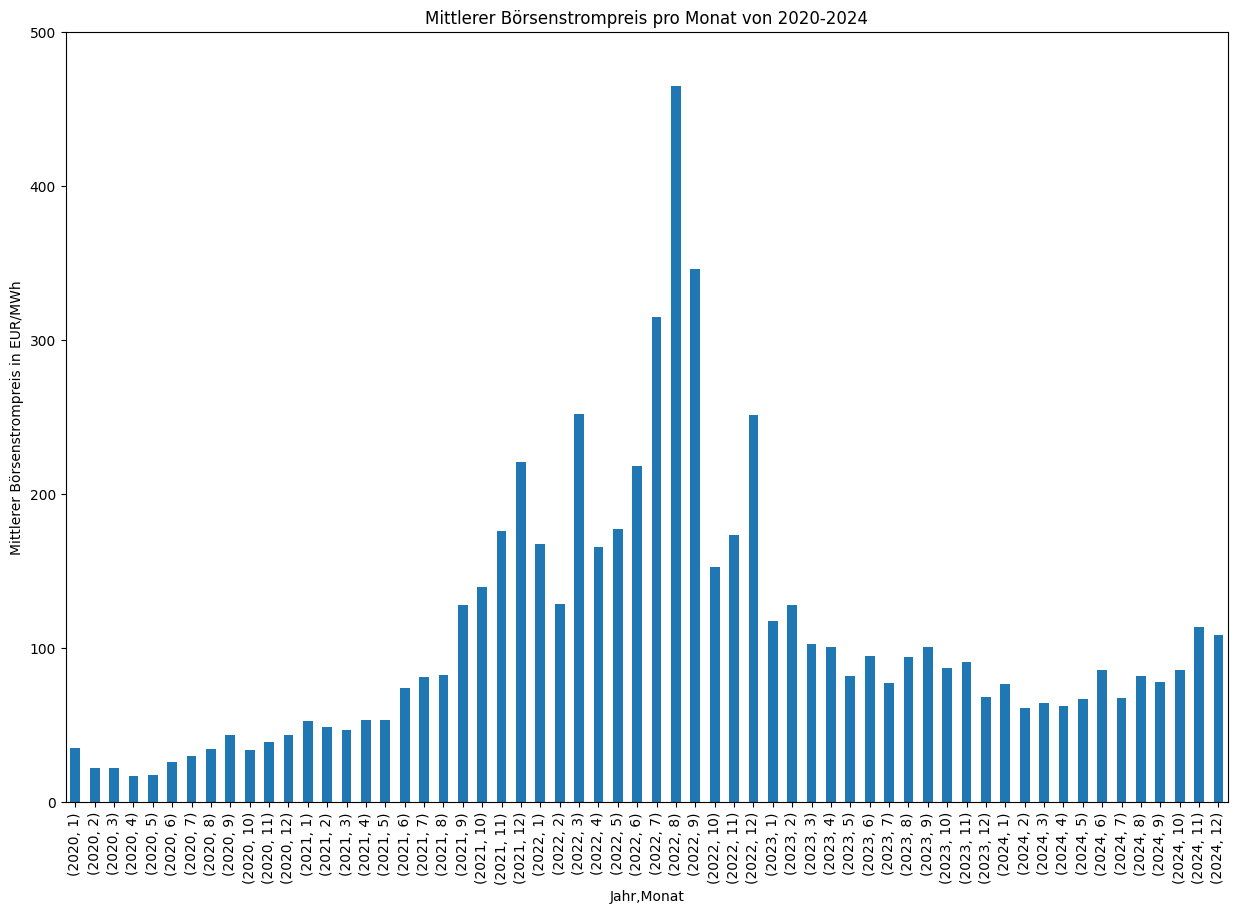

In [186]:
df_year_monthly = df_daily.groupby(['Jahr', 'Monat'])['Day Ahead Auktion Preis (EUR/MWh)'].mean()

df_year_monthly.plot(kind = 'bar', figsize=(15,10))
plt.ylim(0, 500)

plt.title('Mittlerer Börsenstrompreis pro Monat von 2020-2024')
plt.ylabel('Mittlerer Börsenstrompreis in EUR/MWh')


d)

e) Berechnung und Visualisierung der im Mittel mit erneuerbaren Energieträgern erzeugten Energie im Tagesverlauf, indem wir auf die vollen Stunden eines Tages aggregieren. Der df_daily hat als Aggregation für den Tag die Summe der erneuerbaren und nicht erneuerbaren Energie pro Tag. Deswegen gruppieren wir den df_hourly nochmal nach Tagen und nehmen dann für die erneuerbaren Energien den Mittelwert

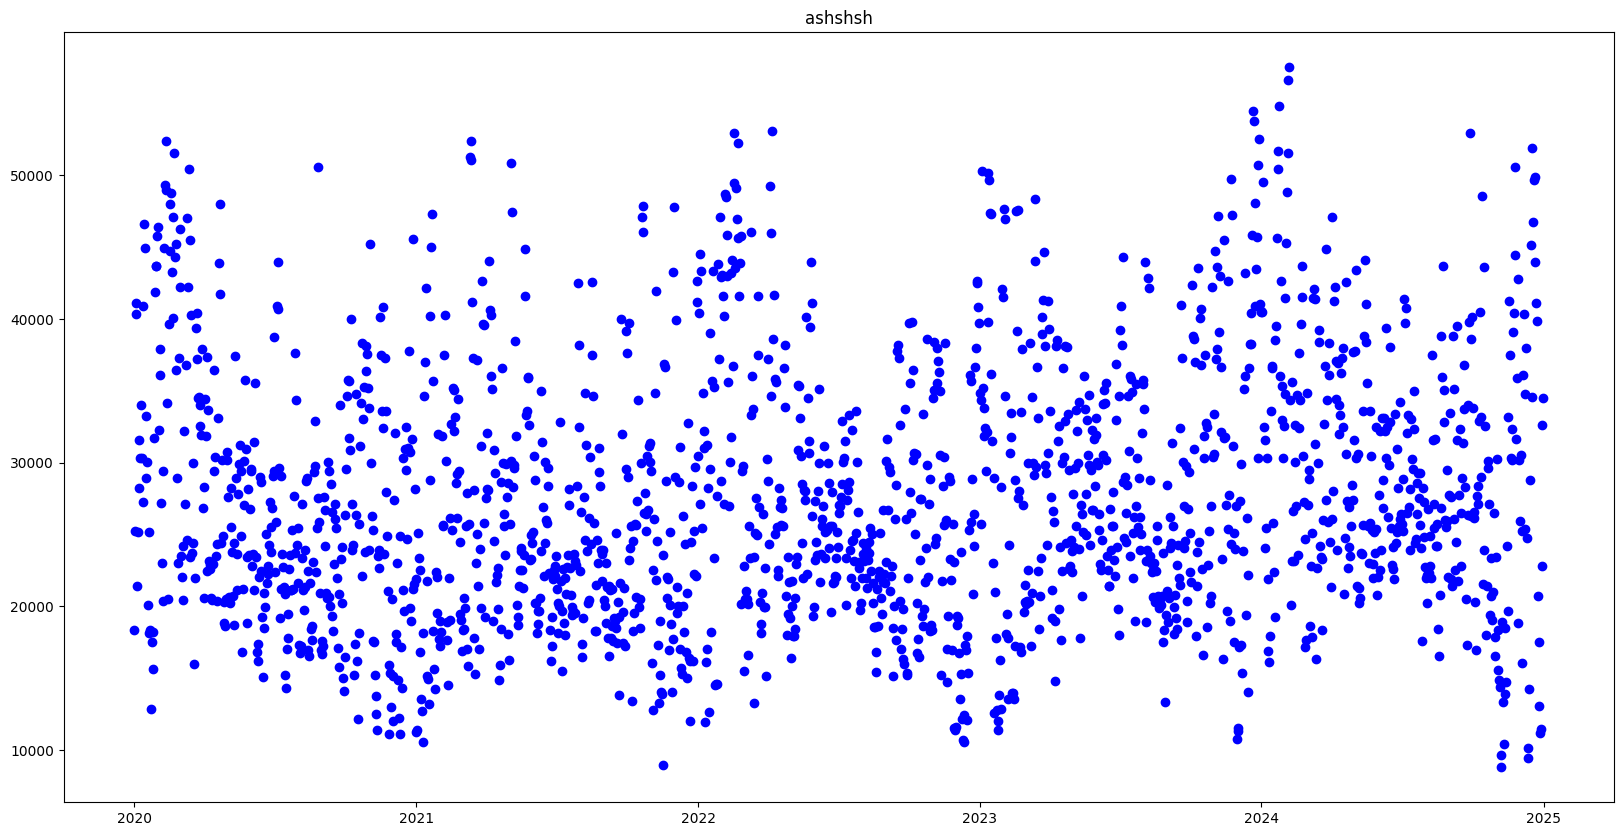

In [187]:
# use df_stunde, which contains the transformed "Datum" as date and not datetime
df_renewable_daily=df_stunde.groupby('Datum')['Leistung erneuerbar (MW)'].mean().reset_index()
df_renewable_daily['Leistung erneuerbar (GW)'] = df_renewable_daily['Leistung erneuerbar (MW)']/1000

# Sinnvolle Darstellung??
plt.figure(figsize=(20, 10))

plt.scatter(df_renewable_daily['Datum'], df_renewable_daily['Leistung erneuerbar (MW)'], label = 'scatter', color = 'blue')
plt.title('ashshsh')
plt.show()




### Aufgabe 6 (Analyse von Stromtarif-Angeboten für Endkunden)
<a id = "aufgabe6"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)

a) Führen Sie die gegebenen Preisvergleichdaten in einem DataFrame namens df_cust zusammen. Exportieren Sie diesen als CSV-Datei namens prices_customers.csv und laden Sie diese mit Ihrer Abgabe auf Moodle hoch. Verwerfen Sie bitte zur Minimierung der Dateigröße alle Spalten, die im weiteren Verlauf nicht mehr verwendet werden. Kommentieren Sie nun den Code zur Datensatzgenerierung aus und lesen Sie die CSV-Datei in den DataFrame df_cust erneut aus dieser Datei ein.


In [ ]:
'''
path = './Daten/Endkundenpreise/'

def extract_date_from_filepath(file):
    file = file.replace(path, "")
    # Concatenate the date out of fixed year 2024 and month/day from folder name
    return "2024-" + file[0:5]

def extract_data_from_json(file):
    assert file.endswith(".json"), "Keine json-Datei uebergeben"
    try:
        # Read and load the json file
        df_temp = pd.read_json(file)
        # Transpose the table: convert the rows to columns
        df_temp = df_temp.T
        # Add date from filename as column
        df_temp['Datum'] = extract_date_from_filepath(file)
        
        return df_temp
    except:
        print("Datei konnte nicht gelesen werden.")

def drop_unnecessary_columns(df):
    columns_to_drop = ['Postleitzahl', 'Jahresverbrauch', 'Abschlagszahlung', 'Verlängerung', 'Kündigungsfrist', 'Grundpreis', 'Arbeitspreis', 'Preisgarantie', 'Grundpreisrabatt:', 'Neukundenbonus', 'Sofortbonus', 'Arbeitspreisrabatt', 'Zusätzlicher Aktionsbonus', 'Blitzbonus', 'Abschlagsrabatt', 'Grundpreisrabatt', 'Winterprämie']
    return df.drop(columns = columns_to_drop)

df_list = []
# https://www.tutorialspoint.com/python/os_listdir.htm
for folder in os.listdir(path):
    combined_path = os.path.join(path, folder, "*json")
    json_files = glob.glob(combined_path)

    for i in range(len(json_files)):
        df_temp = extract_data_from_json(json_files[i])
        df_list.append(df_temp)
        
df_cust = pd.concat(df_list)
df_cust = drop_unnecessary_columns(df_cust)
# https://www.datacamp.com/tutorial/save-as-csv-pandas-dataframe
df_cust.to_csv('prices_customers.csv', index = False, encoding='utf-8')
'''


b) Bereiten Sie die Daten auf die weitere Analyse vor, indem Sie geeignete Datentransformations- und -bereinigungsschritte durchführen.

In [372]:
df_cust = pd.read_csv('prices_customers.csv')
print("Zeilen vor Bereinigung:", df_cust.shape[0])

df_cust['Datum'] = pd.to_datetime(df_cust['Datum'])

def combine_price_columns(row):
    if pd.isna(row['Preis im 1. Jahr*']):
        return row['Preis im 1. Jahr']
    return row['Preis im 1. Jahr*']

def replace_string_from_row(row, column, string, string_to_replace_with):
    if pd.isna(row[column]):
        return row[column]
    if string in row[column]:
        return row[column].replace(string, string_to_replace_with)
    return row[column]

# Combine the two price columns into one
df_cust['Preis'] = df_cust.apply(combine_price_columns, axis = 1)
df_cust = df_cust.drop(columns = ['Preis im 1. Jahr*', 'Preis im 1. Jahr'])
# Drop rows with NaN as Preis, because those rows aren't viable for a comparison later on
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
df_cust = df_cust.dropna(subset=['Preis'])

df_cust['Vertragslaufzeit'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Vertragslaufzeit', " Monate", ""), axis=1)
df_cust['Vertragslaufzeit'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Vertragslaufzeit', " Monat", ""), axis=1)
# Fill NaN values, so that dtype can be converted to int
df_cust['Vertragslaufzeit'] = df_cust['Vertragslaufzeit'].fillna(0)
df_cust['Vertragslaufzeit'] = df_cust['Vertragslaufzeit'].astype(int)

df_cust['Preis'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Preis', " €/Monat", ""), axis=1)
# Change decimal comma, to decimal point for float conversion
df_cust['Preis'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Preis', ",", "."), axis=1)
df_cust['Preis'] = df_cust['Preis'].astype(float)
df_cust = df_cust.rename(columns = {'Preis' : 'Preis im 1. Jahr/ pro Monat in €', 'Vertragslaufzeit' : 'Vertragslaufzeit in Monaten'})

print("Zeilen nach Bereinigung:", df_cust.shape[0])



Zeilen vor Bereinigung: 256340
Zeilen nach Bereinigung: 255663


c) Wie viele verschiedene Tarife wurden insgesamt angeboten? Zu wie vielen Tagen sind pro Stadt Daten vorhanden? Wie viele verschiedene Anbieter haben insgesamt Tarife angeboten?

In [373]:
unique_tariffe = df_cust['Tarif'].unique()
print("Anzahl verschiedender Tarife:" , len(unique_tariffe))

# Occuring Städte in the DataSet
number_of_total_cities = len(df_cust['Stadt'].unique())

# Group with any aggregation to get all unique Datum/Stadt combination entries
grouped_date_city = df_cust.groupby(['Datum', 'Stadt']).agg(Count=('Stadt', 'count')).reset_index()
# Group and count how many different Stadt rows there are for each given date
grouped_date = grouped_date_city.groupby( ['Datum'])['Stadt'].count()
# Filter out the dates that don't have an entry for every Stadt of the DataSet
filtered_dates = grouped_date[grouped_date == number_of_total_cities]
print("Daten für alle Städte sind an", len(filtered_dates), "Tagen vorhanden")

unique_anbieter = df_cust['Anbieter'].unique()
print("Anzahl der Anbieter die insgesamt Tarife angeboten haben:", len(unique_anbieter))

Anzahl verschiedender Tarife: 112
Daten für alle Städte sind an 312 Tagen vorhanden
Anzahl der Anbieter die insgesamt Tarife angeboten haben: 78


d) Ermitteln Sie, welche unterschiedlichen Tarife in Amberg angeboten wurden und visualisieren Sie exemplarisch für die Stadt Amberg den Füllgrad der Daten. Erstellen Sie dazu eine HeatMap, aus der hervorgeht, an welchen Tagen es zu welchen der ermittelten Tarife Angebotsdaten gab.

Anzahl verschiedender Tarife: 77


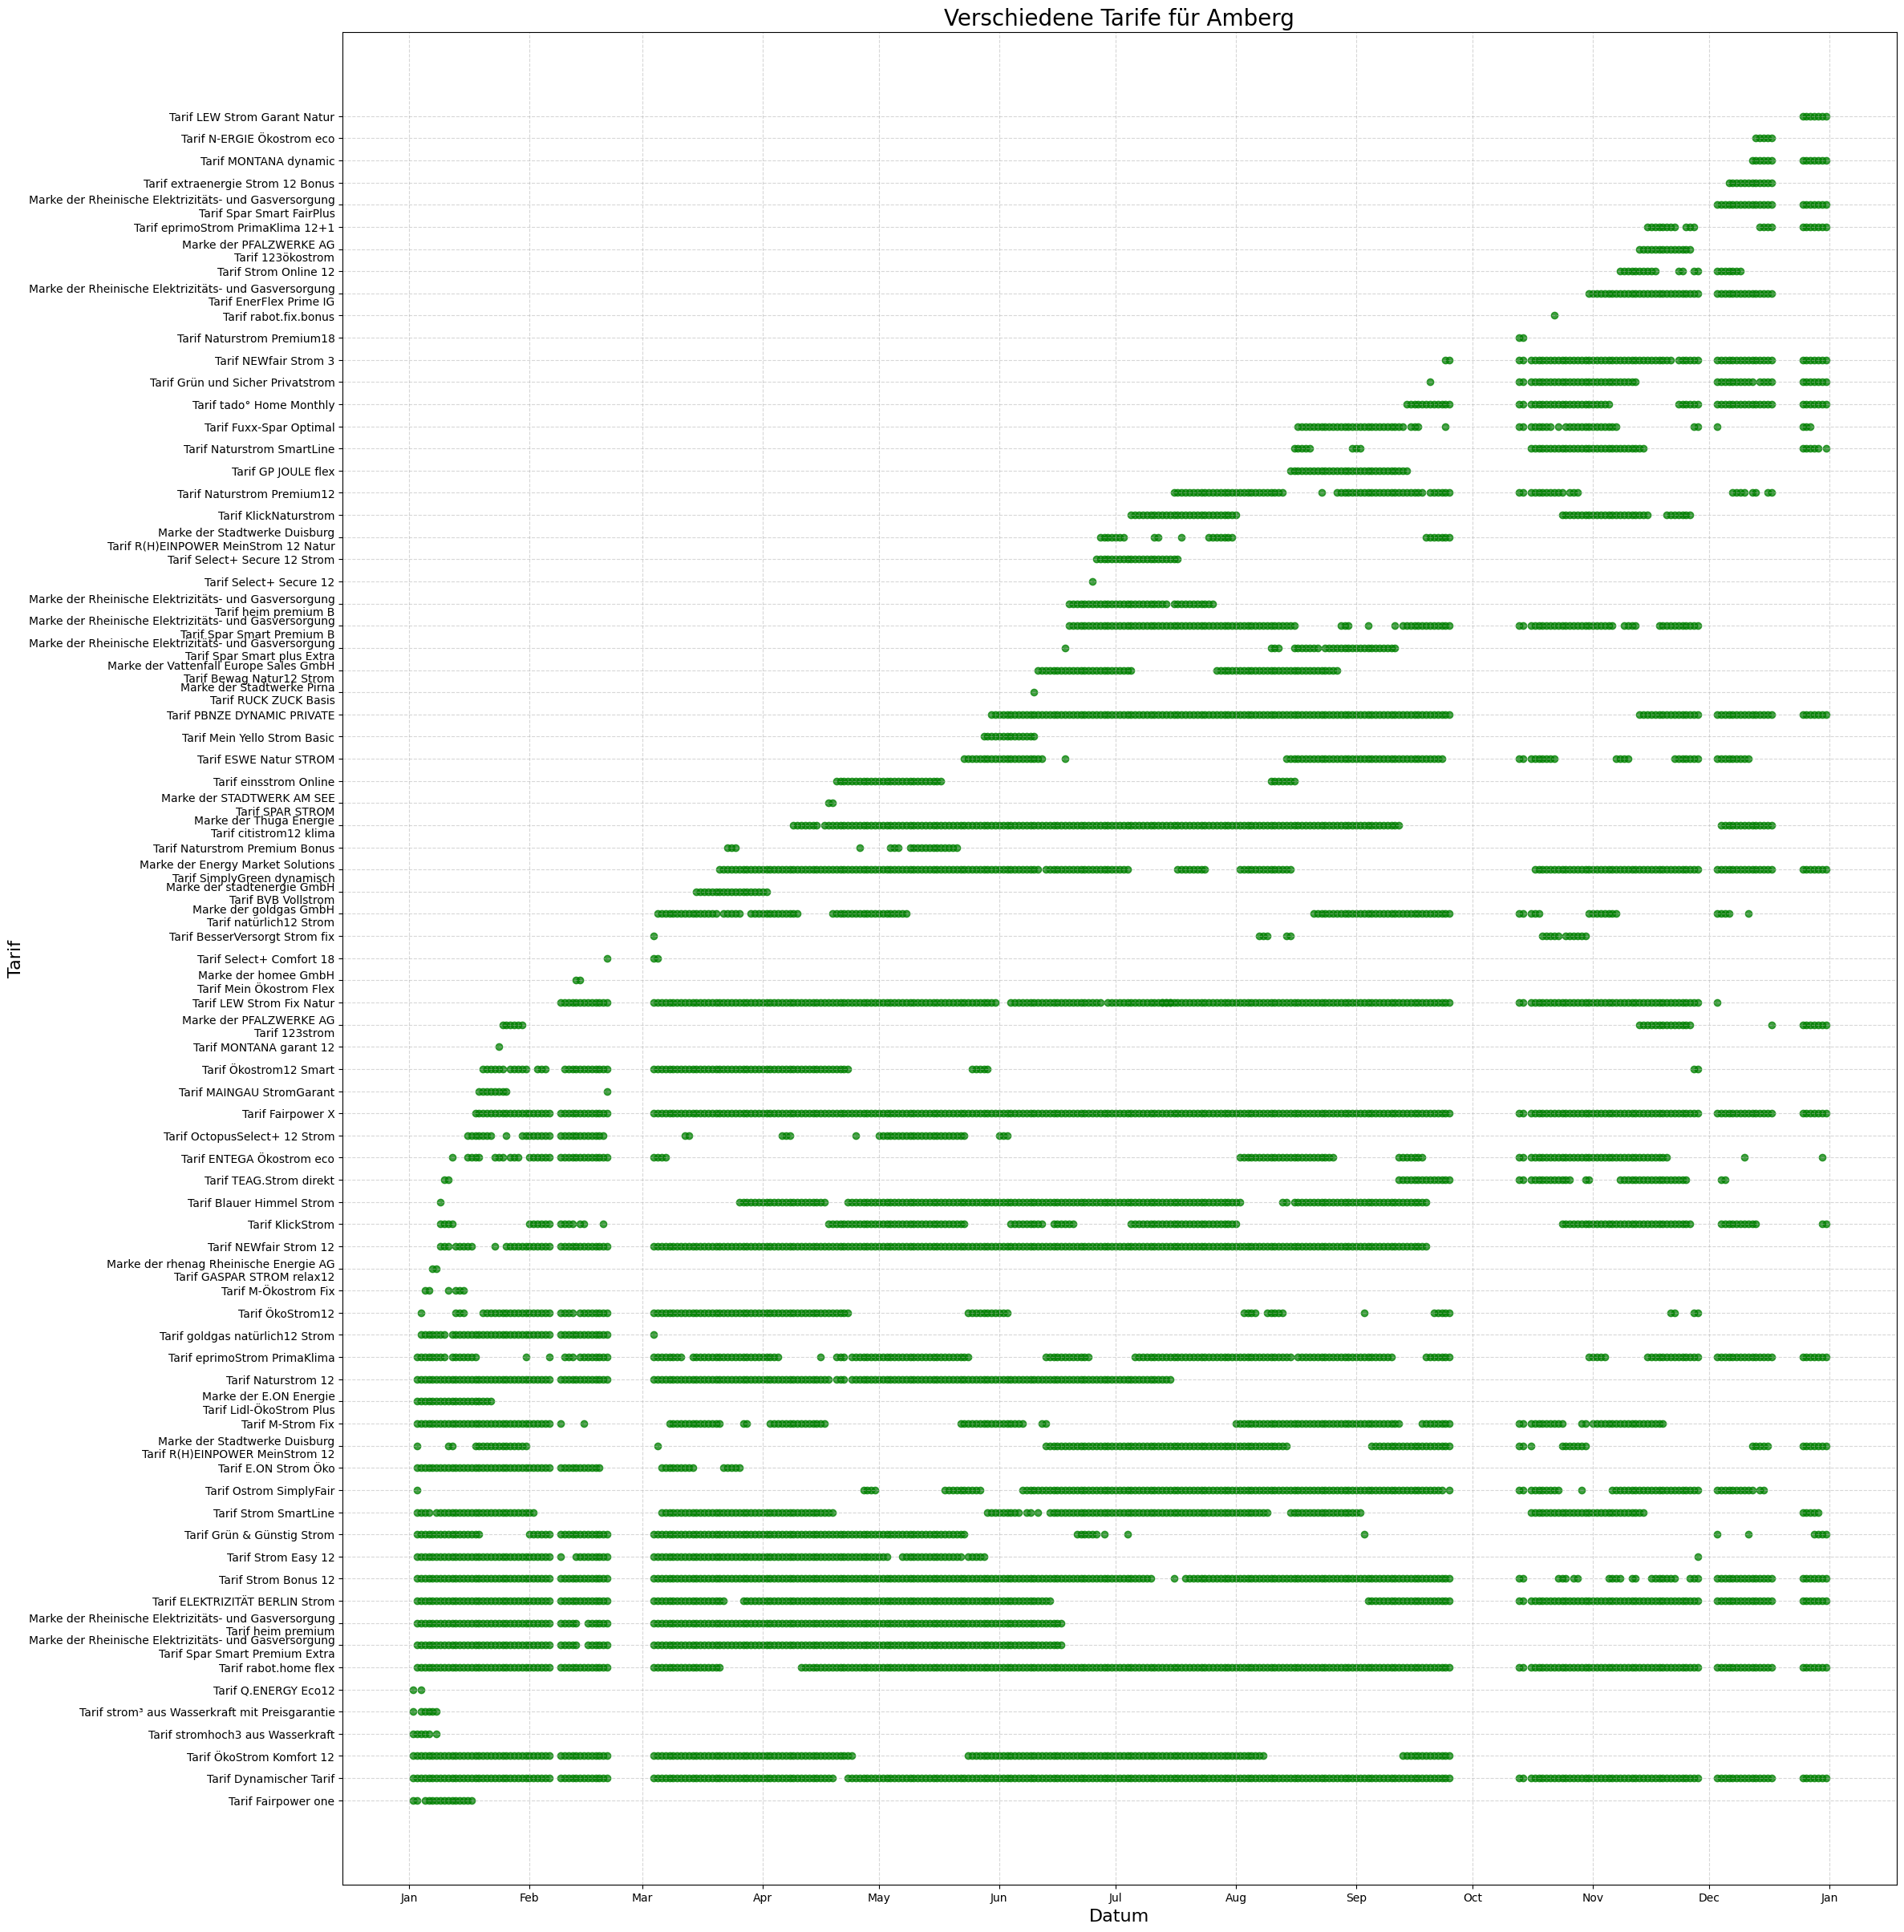

In [374]:
df_amberg = df_cust[df_cust['Stadt'] == 'Amberg']

unique_tariffe_amberg = df_amberg['Tarif'].unique()
print("Anzahl verschiedender Tarife:" , len(unique_tariffe_amberg))

plt.figure(figsize=(25, 30))
# HeatMap: green = the Tarif is offered for the given day, none/white = no offering 
plt.scatter(df_amberg['Datum'], df_amberg['Tarif'], color ='green', alpha=0.75)

# https://stackoverflow.com/questions/57796673/switching-month-numbers-to-month-names-on-x-axis-of-histogram-matplotlib
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

plt.xlabel('Datum', fontsize=16) 
plt.ylabel('Tarif', fontsize=16)
plt.title('Verschiedene Tarife für Amberg', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


e) Visualisieren Sie die durchschnittliche Preisentwicklung im Verlauf des Jahres 2024 über alle Tarife und Orte hinweg. Berücksichtigen Sie dabei nur Tarife, bei denen die Vertragslaufzeit mindestens 12 Monate beträgt. Verwenden Sie dazu den Preis im 1. Jahr, der den monatlichen Preis unter Berücksichtigung des Grundpreises, des Arbeitspreises und von Bonuszahlungen o.ä. enthält. Untersuchen Sie anschließend den Zusammenhang zum Börsenstrompreis, indem Sie geeignete Kenngrößen berechnen und weitere Diagramme erstellen.

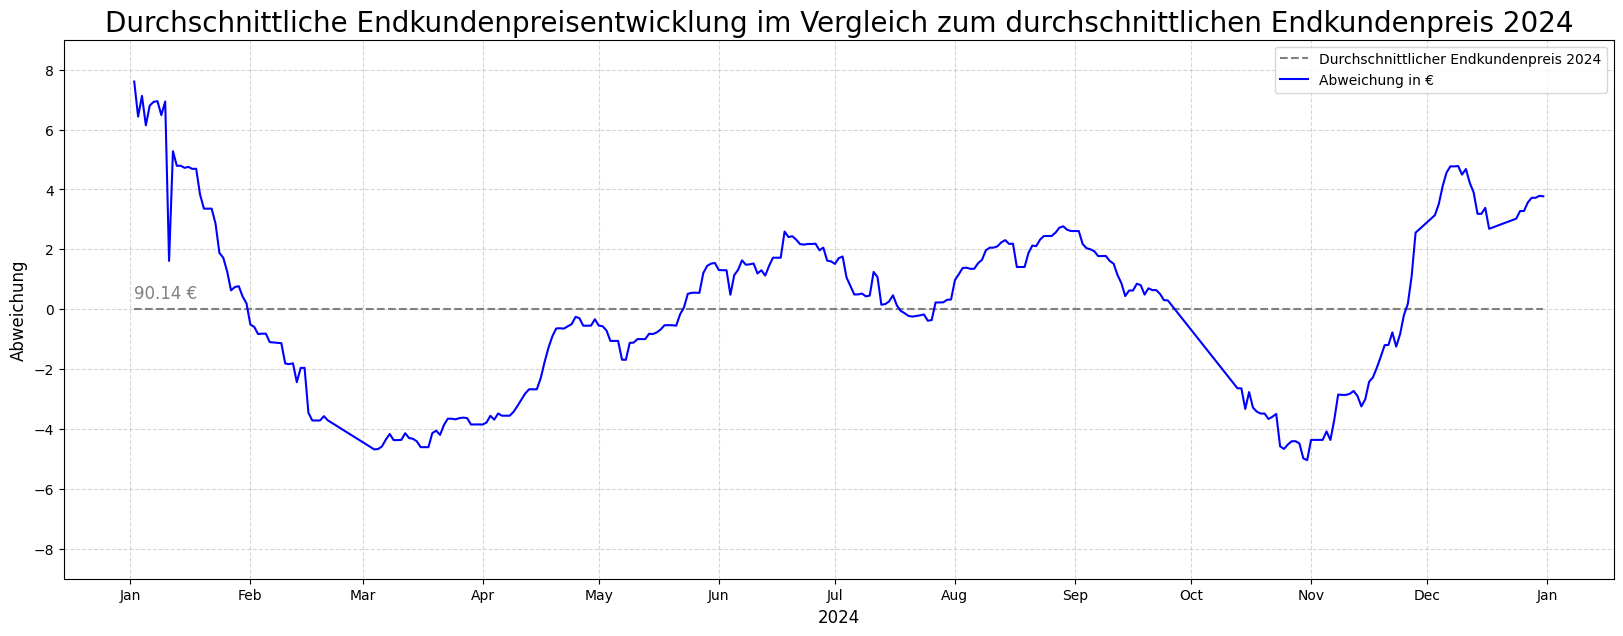

In [394]:
filtered_12_months = df_cust[df_cust['Vertragslaufzeit in Monaten'] >= 12]
df_mean_prices = filtered_12_months.groupby(['Datum']).agg(MeanPrice =('Preis im 1. Jahr/ pro Monat in €', 'mean')).reset_index()

mean_price_total = df_mean_prices['MeanPrice'].mean()

df_mean_prices['Difference to Total Mean'] = (df_mean_prices['MeanPrice'] - mean_price_total)
# Constant value column for plotting the base line
df_mean_prices['Total Mean'] = 0

plt.figure(figsize=(20, 7))
# Mean/Base line
plt.plot(df_mean_prices['Datum'], df_mean_prices['Total Mean'], label = 'Durchschnittlicher Endkundenpreis 2024', color = 'gray', linestyle='--')
# Label for Mean/Base line
mean_line_label = str(round(mean_price_total,2)) + " €"
plt.text(df_mean_prices['Datum'].min(), 0.35, mean_line_label, color='gray', fontsize=12)

# Price Deviation line
plt.plot(df_mean_prices['Datum'], df_mean_prices['Difference to Total Mean'], label = 'Abweichung in €', color = 'blue')

#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
# Center mean price, to balance out the appearance of change
plt.ylim(bottom = -9, top = 9)

plt.xlabel('2024', fontsize = 12) 
plt.ylabel('Abweichung', fontsize = 12)
plt.title('Durchschnittliche Endkundenpreisentwicklung im Vergleich zum durchschnittlichen Endkundenpreis 2024', fontsize=20)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.grid(True, linestyle = '--', alpha = 0.5)

plt.legend()
plt.show()

df_mean_prices = df_mean_prices.drop(columns = ['Difference to Total Mean', 'Total Mean'])


Vergleich Endkundenpreis zu Börsenstrompreis

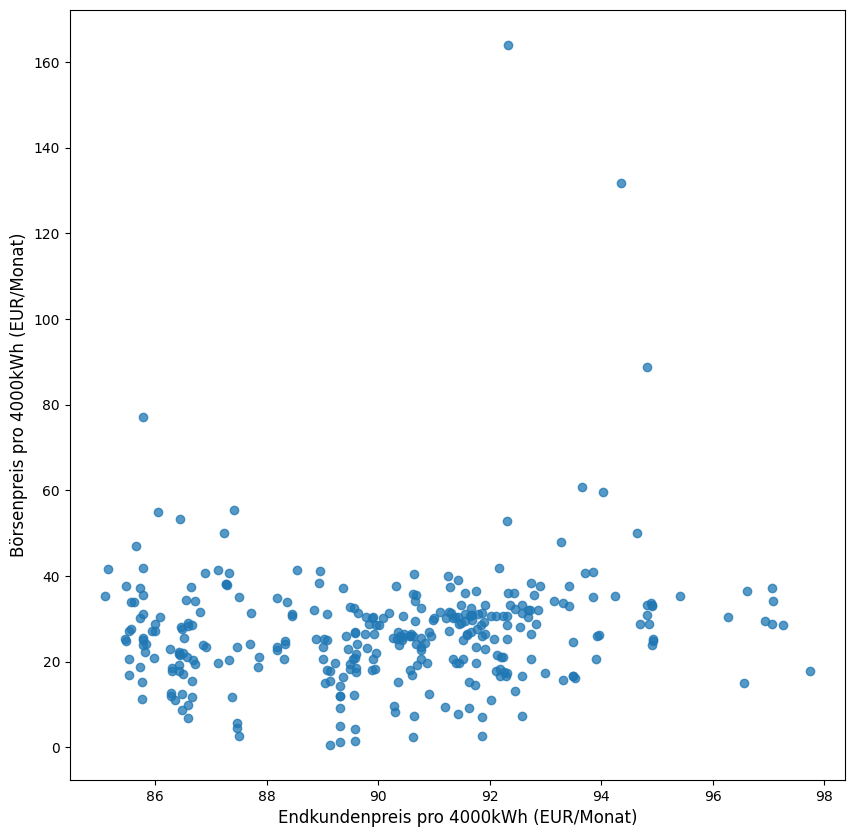

,Datum,Endkundenpreis pro 4000kWh (EUR/Monat),Day Ahead Auktion Preis (EUR/MWh),Börsenpreis pro 4000kWh (EUR/Monat)
0,2024-01-02,97.740308,53.073333,17.691111
1,2024-01-03,96.570094,45.215000,15.071667
2,2024-01-04,97.261390,85.410000,28.470000
3,2024-01-05,96.278695,91.370417,30.456806
4,2024-01-06,96.936857,88.724583,29.574861
...,...,...,...,...
320,2024-12-27,93.703963,121.706250,40.568750
321,2024-12-28,93.859193,122.638333,40.879444
322,2024-12-29,93.859193,105.280417,35.093472
323,2024-12-30,93.924182,78.155833,26.051944


In [ ]:
df_kunden_boerse = pd.merge(df_mean_prices, df_daily, on = 'Datum', how = 'left', validate='one_to_one')
df_kunden_boerse = df_kunden_boerse.drop(columns = ['Leistung nicht erneuerbar (MW)', 'Leistung erneuerbar (MW)', 'Jahr', 'Monat'])
df_kunden_boerse = df_kunden_boerse.rename(columns = {'MeanPrice': 'Endkundenpreis pro 4000kWh (EUR/Monat)'})

# 1 MWh = 1.000 kWh
'''
df_kunden_boerse['Börsenpreis pro kWh (EUR)'] = (df_kunden_boerse['Day Ahead Auktion Preis (EUR/MWh)'] / 1000)
df_kunden_boerse['Endkundenpreis pro kWh (EUR)'] = (df_kunden_boerse['Endkundenpreis pro 4000kWh (EUR/Monat)'] * 12) / 4000
'''

# Adjust Auktion Preis to 4000kWh and calculate a forecast for one year per month with that
df_kunden_boerse['Börsenpreis pro 4000kWh (EUR/Monat)'] = (df_kunden_boerse['Day Ahead Auktion Preis (EUR/MWh)'] * 4)/12


plt.figure(figsize=(10, 10))
plt.scatter(df_kunden_boerse['Endkundenpreis pro 4000kWh (EUR/Monat)'], df_kunden_boerse['Börsenpreis pro 4000kWh (EUR/Monat)'], alpha=0.75)

plt.xlabel('Endkundenpreis pro 4000kWh (EUR/Monat)', fontsize = 12) 
plt.ylabel('Börsenpreis pro 4000kWh (EUR/Monat)', fontsize = 12)
plt.show()

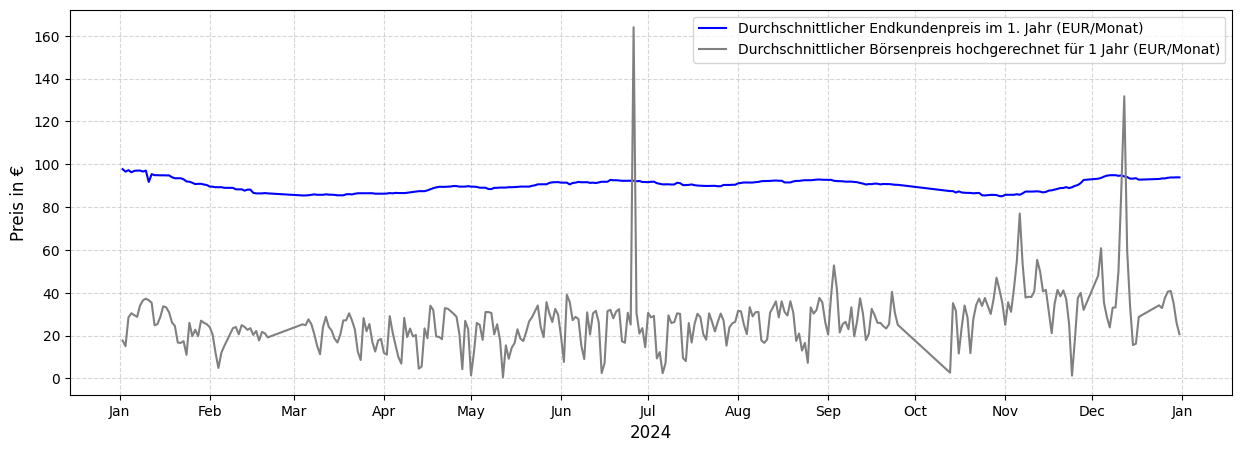

In [405]:
plt.figure(figsize=(15, 5))
plt.plot(df_kunden_boerse['Datum'], df_kunden_boerse['Endkundenpreis pro 4000kWh (EUR/Monat)'], label = 'Durchschnittlicher Endkundenpreis im 1. Jahr (EUR/Monat)', color = 'blue')
plt.plot(df_kunden_boerse['Datum'], df_kunden_boerse['Börsenpreis pro 4000kWh (EUR/Monat)'] , label = 'Durchschnittlicher Börsenpreis hochgerechnet für 1 Jahr (EUR/Monat)', color = 'gray')
plt.ylabel('Preis in €', fontsize = 12) 
plt.xlabel('2024', fontsize = 12) 
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()
plt.show()

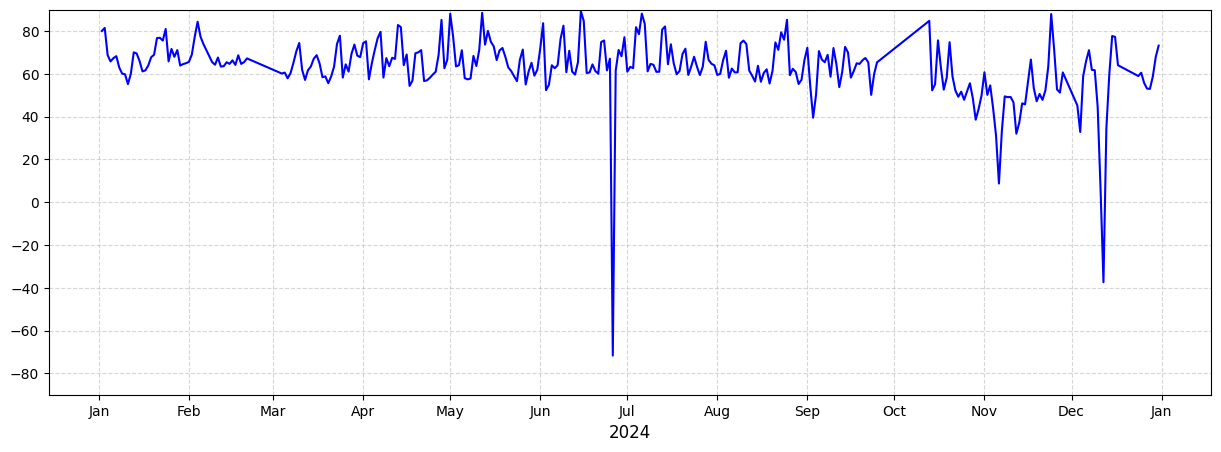

-71.68683421516756
89.30994552414606


In [406]:
df_kunden_boerse['Differenz Anbieter/Endkunde'] = df_kunden_boerse['Endkundenpreis pro 4000kWh (EUR/Monat)'] - df_kunden_boerse['Börsenpreis pro 4000kWh (EUR/Monat)'] 

plt.figure(figsize=(15, 5))
plt.plot(df_kunden_boerse['Datum'], df_kunden_boerse['Differenz Anbieter/Endkunde'], color = 'blue')
plt.xlabel('2024', fontsize = 12) 
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.grid(True, linestyle = '--', alpha = 0.5)

plt.ylim(-90,90)
plt.show()

print(df_kunden_boerse['Differenz Anbieter/Endkunde'].min())
print(df_kunden_boerse['Differenz Anbieter/Endkunde'].max())

i) Im Merkmal Anbieter befinden sich kurze Beschreibungen der Anbieter und der Tarife. Erstellen Sie mit Hilfe des Pakets WordCloud eine Wortwolke für die Anbieter-Beschreibungen und untersuchen Sie, welche Schlagworte besonders häufig auftreten.

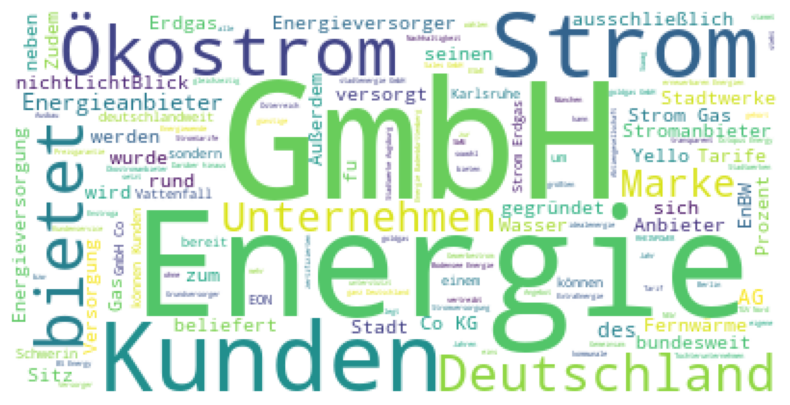

In [407]:
def remove_punctuation_from_anbieter(anbieter):
    punctuations = [
        ".", ",", "/", "&", "-", "_", ":", ";", "!", "?", "#", "%", "$", "@", "^", "+",
        "=", "(", ")", "[", "]", "{", "}", "<", ">", "|", "~", "'", "`"]
    for p in punctuations:
        anbieter = anbieter.replace(p, "")
    return anbieter
    
def remove_non_buzzwords_from_anbieter(anbieter):
    anbieter_words = anbieter.split() # Isolate each word of Anbieter

    words_to_remove = [
        'der', 'die', 'das', 'und', 'ein', 'eine', 'einen', 'mit', 'ist', 'den', 'dem', 'zu', 'von', 'vom', 
        'auf', 'im', 'an', 'für', 'am', 'als', 'es', 'aber', 'auch', 'aus', 'bei', 'dass', 'um'
        'du', 'er', 'sie', 'wir', 'ihr', 'ihnen', 'ihm', 'euch', 'mir', 'mich', 
        'mein', 'meine', 'dein', 'deine', 'sein', 'seine', 'ihr', 'ihre', 
        'noch', 'schon', 'oder', 'so', 'wie', 'was', 'wer', 'wenn', 'beim'
        'warum', 'weil', 'dann', 'doch', 'nur', 'diese', 'dieser', 'dieses', 
        'jeder', 'jede', 'jedes', 'keiner', 'keine', 'kein', 'welche', 'welcher', 
        'man', 'damit', 'über', 'unter', 'haben', 'hat', 'sein', 'sind', 'war', 'waren', 
        'dabei', 'in', 'seit', 'durch', 'ihren', 'einer', 'sowie']

    filtered_words = []
    
    for word in anbieter_words:
        # Only keep words that are buzzwords
        if word.lower() not in words_to_remove:
            filtered_words.append(word)

    # https://www.w3schools.com/python/ref_string_join.asp
    return ' '.join(filtered_words)

unique_anbieter_strs = df_cust['Anbieter'].unique()

for i in range(len(unique_anbieter_strs)):
    unique_anbieter_strs[i] = remove_punctuation_from_anbieter(unique_anbieter_strs[i])
    unique_anbieter_strs[i] = remove_non_buzzwords_from_anbieter(unique_anbieter_strs[i])

# Create one String out of all different Anbieter 
combined_text = ' '.join(unique_anbieter_strs)

cloud = WordCloud(background_color='white').generate(combined_text)
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')
plt.show()


### Quellenverzeichnis
<a id = "quellenverzeichnis"></a>

[1] https://www.geeksforgeeks.org/how-to-read-all-csv-files-in-a-folder-in-pandas/

[2] https://statistikguru.de/python/python-auflisten-dateien-verzeichnis.html

[3] https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

[4] https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html#pandas.Series.dt.year

[5] https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[6] Chat GPT 

    Prompt (am 05.01.2025): 

    #Using column Jahr, which contains year as string
    # We use a copy to avoid the SettingWithCopyWarning that occurs when we modifiy a view of the original df [5]
    year_2020 = df_daily[df_daily['Jahr'] == '2020'].copy()
    year_2021 = df_daily[df_daily['Jahr'] == '2021'].copy()

    year_2020['Datum'] = year_2020['Datum'].astype(str)
    year_2021['Datum'] = year_2021['Datum'].astype(str)

    # ertste Vorkommen von 2020 auf 2000 setzten

    year_2020['Datum'] = year_2020['Datum'].str.replace('2020', '2000')

    year_2021['Datum'] = year_2021['Datum'].str.replace('2021', '2000')

    year_2020['Datum'] = pd.to_datetime(year_2020['Datum'])
    year_2021['Datum'] = pd.to_datetime(year_2021['Datum'])

    plt.figure(figsize=(12, 6))
    plt.plot(year_2020['Datum'], year_2020['Day Ahead Auktion Preis (EUR/MWh)'], label = '2020', color = 'green')
    plt.plot(year_2021['Datum'], year_2021['Day Ahead Auktion Preis (EUR/MWh)'], label = '2021', color = 'blue')

    Wie kann ich die x-Achse so verändern, dass nicht mehr Jahr-Monat dort steht, sondern nur noch der Monat (also alle Monate von 1-12). Die Darstellung der Tagesdaten soll aber gleich bleiben

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)